# Rebuild estimation of feature count from using a grid method

#### Parameters that **have to be** adjustable:

- Size of the grid (i.e. how large is the side of each square)
- Size of the counting square (i.e. how large is the side of each counting square). To consider:
    - Size relative to grid square? Percentage of grid square side or of grid square area?
    - or make its size absolute? --> min > 0 & max = grid square side

### Parameters that **should** adjustable:

- inclusion / exclusion criteria:
    - on which sides of the square / cube is a ROI included / excluded
- position of the counting square:
    - upper left, upper center, upper right
    - middle left, middle center, middle right
    - lower left, lower center, lower right

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import roifile

from typing import Dict, Tuple, List

### Classes:

In [2]:
class ImageTile:
    
    def __init__(self, tiles_row_id: int, tiles_col_id: int, tile: np.ndarray):
        self.row_id = tiles_row_id
        self.col_id = tiles_col_id
        self.image = tile
        self.height, self.width = tile.shape[0:2]
        self.all_corner_coords = self._calculate_all_corner_coords()
        self.bounding_box_roi = self._convert_corner_coords_to_bounding_box_roi()
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    def _convert_corner_coords_to_bounding_box_roi(self):
        coords = self.all_corner_coords
        return Polygon([coords['upper_left'], coords['upper_right'], coords['lower_right'], coords['lower_left']])
    
    def _calculate_all_corner_coords(self) -> Dict:
        all_corner_coords = {}
        upper_left = (self.row_id * self.height, self.col_id * self.width)
        all_corner_coords['upper_left'] = upper_left
        all_corner_coords['upper_right'] = (upper_left[0], upper_left[1] + self.width)
        all_corner_coords['lower_left'] = (upper_left[0] + self.height, upper_left[1])
        all_corner_coords['lower_right'] = (upper_left[0] + self.height, upper_left[1] + self.width)
        return all_corner_coords

### Functions:

In [30]:
# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
def reshape_split(image: np.ndarray, kernel_size: Tuple[int, int]) -> np.ndarray:
    
    image_height, image_width, image_channels = image.shape # might crash with grayscale images?
    tile_height, tile_width = kernel_size
    
    if (image_height % tile_height != 0) or (image_width % tile_width != 0):
        image = resize_image_by_padding_bottom_right(image = image, kernel_size = kernel_size)
        image_height, image_width, image_channels = image.shape
        
    tiled_array = image.reshape(image_height // tile_height,
                                tile_height,
                                image_width // tile_width,
                                tile_width, 
                                image_channels)
    tiled_array = tiled_array.swapaxes(1,2)    
    return tiled_array, image


def resize_image_by_padding_bottom_right(image: np.ndarray, kernel_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width = image.shape[:2]
    pixels_required_for_height = kernel_size[0] - image_height % kernel_size[0]
    pixels_required_for_width = kernel_size[1] - image_width % kernel_size[1]
    return np.pad(image, ((0, pixels_required_for_height), (0, pixels_required_for_width), (0, 0)))
    

## Testing:

In [25]:
# Load image and roi
image = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/max_rgb.png')

loaded_roi = roifile.ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/max_rgb.roi')
row_coords = loaded_roi.coordinates()[:, 1]
col_coords = loaded_roi.coordinates()[:, 0]
area_roi = Polygon(np.asarray(list(zip(row_coords, col_coords))))

In [31]:
tiles, resized_image = reshape_split(image = image, kernel_size = (400, 400))

In [33]:
overlapping_tiles = []
for row_id in range(tiles.shape[0]):
    for col_id in range(tiles.shape[1]):
        selected_tile = ImageTile(tiles_row_id = row_id, tiles_col_id = col_id, tile = tiles[row_id, col_id])
        if (selected_tile.bounding_box_roi.overlaps(area_roi)) or (selected_tile.bounding_box_roi.within(area_roi)):
            overlapping_tiles.append(selected_tile)

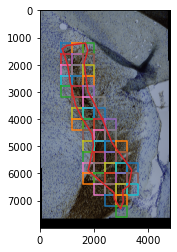

In [35]:
plt.imshow(resized_image)
for tile in overlapping_tiles:
    plt.plot(tile.bounding_box_x_for_plotting, tile.bounding_box_y_for_plotting)
plt.plot(area_roi.boundary.xy[1], area_roi.boundary.xy[0])
plt.show()